In this exercise, we will
 consider integral constraints of the form $q = \int_{0}^{1} f(x) \, dx$.

  That is, the learned function f must integrate to q over the integral [0,1]. Your
 task is to extend Gaussian Processes to integrate these integral constraints. As an
 example case, we will consider learning the function $g(x) = -(\sin(6\pi x))^2 + 6x^2 - 5x^4 + \frac{3}{2}$  on the interval x ∈ [0, 1] with the integral constraint $q = 2$.

We will first consider the simpler problem of fitting a Gaussian Process without
 the additional constraint. This will form your baseline. You will first implement a
 standard GP model using the maximum a-posteriori estimate of hyper parameters
 and compare that to the sampled GP using NUTS.
 As dataset, we assume that observations are given by: $y_i = g(x_i) + \epsilon$, $\epsilon \sim \mathcal{N}(0, 0.01)$, where the observations are the grid $x_i = \frac{i-1}{l-1}$, $i=1,\ldots,l$ with $l=30$. Partition
 the set of points randomly into a set of 20 points for training and 10 for evaluation.

In [2]:
%pip install pyro-ppl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 3.1 MB/s eta 0:00:00


In [3]:
import torch
import pyro
import pyro.contrib.gp as gp
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
import pyro.distributions as dist
from pyro.distributions import Normal
import matplotlib.pyplot as plt
import numpy as np


In [4]:
# Set random seed for reproducibility
pyro.set_rng_seed(42)

# Define the true function g(x)
def g(x):
    return (- (np.sin(6*np.pi*x))**2 + 6*x**2 - 5*x**4 + 3/2)

# Generate data
l = 30
x = torch.linspace(0, 1, l).unsqueeze(-1)  # Shape (l, 1)
y = g(x).squeeze() + torch.normal(0, 0.01, size=(l,))  # Shape (l,)

Step 0, Loss: 27.8411922454834
Step 100, Loss: 18.77650260925293
Step 200, Loss: 18.774728775024414
Step 300, Loss: 18.775068283081055
Step 400, Loss: 18.775848388671875
Step 500, Loss: 18.774951934814453
Step 600, Loss: 18.774953842163086
Step 700, Loss: 18.774335861206055
Step 800, Loss: 18.774730682373047
Step 900, Loss: 18.7746639251709


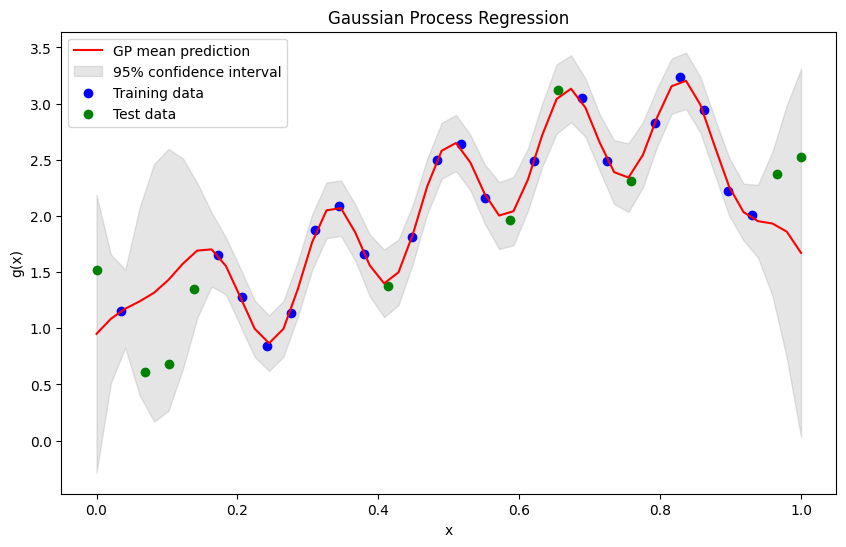

In [5]:
# Split into training and testing data
indices = torch.randperm(l)
train_indices = indices[:20]
test_indices = indices[20:]

x_train, y_train = x[train_indices], y[train_indices]
x_test, y_test = x[test_indices], y[test_indices]

pyro.clear_param_store()
kernel = gp.kernels.RBF(input_dim=1)
gpr = gp.models.GPRegression(x_train, y_train, kernel, noise=torch.tensor(0.01))

# kernel.lengthscale = pyro.nn.PyroSample(dist.LogNormal(0.0, 1.0))  # Prior for lengthscale
# kernel.variance = pyro.nn.PyroSample(dist.LogNormal(0.0, 1.0))     # Prior for variance

# Set priors on the kernel hyperparameters
gpr.kernel.lengthscale = pyro.nn.PyroSample(pyro.distributions.HalfNormal(0.05))
gpr.kernel.variance = pyro.nn.PyroSample(pyro.distributions.HalfNormal(1.0))

# Use Trace_ELBO for the loss
loss_fn = pyro.infer.Trace_ELBO().differentiable_loss

# Define the optimizer
optimizer = torch.optim.Adam(gpr.parameters(), lr=0.01)

# Training loop
losses = []
num_steps = 1000
for i in range(num_steps):
    optimizer.zero_grad()  # Clear gradients
    loss = loss_fn(gpr.model, gpr.guide)  # Compute the Trace_ELBO loss
    loss.backward()         # Backpropagate
    optimizer.step()        # Update parameters
    #add noise
    gpr.noise = torch.tensor(0.01)
    losses.append(loss.item())
    if i % 100 == 0:
        print(f"Step {i}, Loss: {loss.item()}")

# Predictions for plotting
x_plot = torch.linspace(0, 1, 50).unsqueeze(-1)
mean, variance = gpr(x_plot, full_cov=False, noiseless=False)
std_dev = variance.sqrt()

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(x_plot.numpy(), mean.detach().numpy(), label="GP mean prediction", color="red")
plt.fill_between(
    x_plot.squeeze().numpy(),
    (mean - 1.96 * std_dev).detach().numpy().squeeze(),
    (mean + 1.96 * std_dev).detach().numpy().squeeze(),
    color="gray",
    alpha=0.2,
    label="95% confidence interval",
)
plt.scatter(x_train.numpy(), y_train.numpy(), color="blue", label="Training data")
plt.scatter(x_test.numpy(), y_test.numpy(), color="green", label="Test data")
plt.title("Gaussian Process Regression")
plt.xlabel("x")
plt.ylabel("g(x)")
plt.legend()
plt.show()





We chose the Gaussian kernel (the RBF kernel) for this task.
The parameters of the kernel are lengthscale and variance, the prior of which is set to a log-normal distribution.
The noise is set to a fixed value of 0.01.

The learned kernel parameters are printed above. The plot shows the true function with noise, the training and test data points, the GP mean prediction, and the 95% confidence interval around the mean prediction.

In [6]:
# Compute test likelihood for MAP
def compute_test_likelihood_map(gpr_model, x_test, y_test):
    # Predict the mean and variance on the test set
    mean_test, variance_test = gpr_model(x_test, full_cov=False, noiseless=False)

    # Compute the log-likelihood of the test data
    log_likelihood = Normal(mean_test, variance_test.sqrt()).log_prob(y_test).sum()
    return log_likelihood.item()

map_likelihood = compute_test_likelihood_map(gpr, x_test, y_test)
print("MAP Test Log-Likelihood:", map_likelihood)

print("MAP Estimate of θ*: ")
print(f"Lengthscale: {gpr.kernel.lengthscale.item()}")
print(f"Variance: {gpr.kernel.variance.item()}")

MAP Test Log-Likelihood: -1.747136116027832
MAP Estimate of θ*: 
Lengthscale: 0.06955824792385101
Variance: 1.9085253477096558


In [7]:
from pyro.infer.mcmc import MCMC, NUTS
# Define the NUTS sampler
nuts_kernel = NUTS(gpr.model)

# Run MCMC
mcmc = MCMC(nuts_kernel, num_samples=1000, warmup_steps=200, num_chains=2,disable_progbar=True)
mcmc.run()

# Extract posterior samples
posterior_samples = mcmc.get_samples()


/usr/local/lib/python3.10/dist-packages/pyro/infer/mcmc/api.py:499: UserWarning: num_chains=2 is more than available_cpu=1. Chains will be drawn sequentially.
  warnings.warn(


Posterior samples for lengthscale: tensor([0.0644, 0.0670, 0.0714, 0.0748, 0.0638, 0.0656, 0.0618, 0.0596, 0.0679,
        0.0638, 0.0720, 0.0719, 0.0725, 0.0752, 0.0713, 0.0752, 0.0687, 0.0697,
        0.0752, 0.0726])
Posterior samples for variance: tensor([1.8177, 2.1674, 1.6868, 2.5436, 1.9558, 1.8159, 2.0670, 2.1047, 2.2797,
        1.6989, 2.3240, 2.2197, 2.6262, 2.3329, 1.5747, 2.2755, 2.4852, 2.4549,
        2.2745, 1.6651])
Posterior log-likelihood (test set): -1.5747132301330566


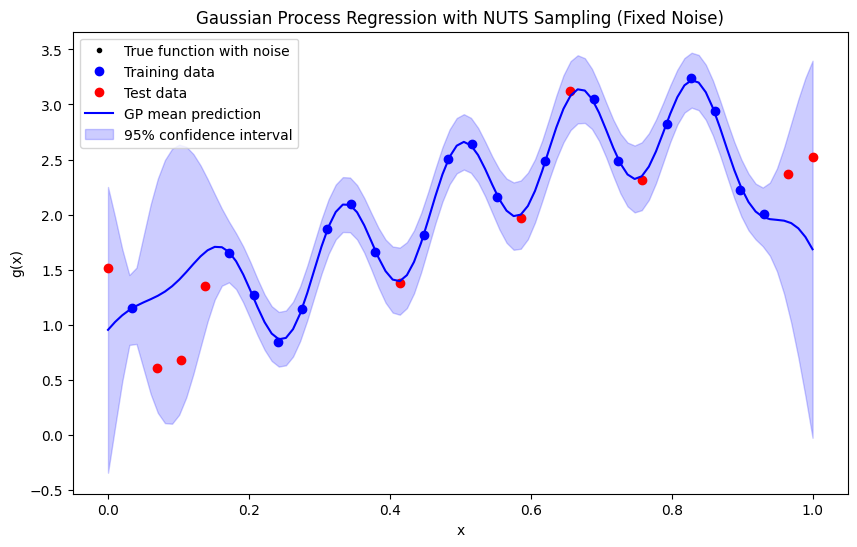

In [8]:
# only print the first 20 samples
print("Posterior samples for lengthscale:", posterior_samples["kernel.lengthscale"][:20])
print("Posterior samples for variance:", posterior_samples["kernel.variance"][:20])

# Use the posterior mean to make predictions
lengthscale_mean = posterior_samples["kernel.lengthscale"].mean().item()
variance_mean = posterior_samples["kernel.variance"].mean().item()

# Update the kernel with the posterior mean parameters
kernel.lengthscale = torch.tensor(lengthscale_mean)
kernel.variance = torch.tensor(variance_mean)

# Predict on test data
mean_test, variance_test = gpr(x_test, full_cov=False, noiseless=False)
log_likelihood_test = (
    pyro.distributions.Normal(mean_test, variance_test.sqrt()).log_prob(y_test).sum()
)
print("Posterior log-likelihood (test set):", log_likelihood_test.item())

# Plot predictions
x_plot = torch.linspace(0, 1, 100).unsqueeze(-1)
mean_plot, variance_plot = gpr(x_plot, full_cov=False, noiseless=False)
std_plot = variance_plot.sqrt()

plt.figure(figsize=(10, 6))
plt.plot(x.numpy(), y.numpy(), "k.", label="True function with noise")
plt.plot(x_train.numpy(), y_train.numpy(), "bo", label="Training data")
plt.plot(x_test.numpy(), y_test.numpy(), "ro", label="Test data")
plt.plot(x_plot.numpy(), mean_plot.detach().numpy(), "b-", label="GP mean prediction")
plt.fill_between(
    x_plot.squeeze().numpy(),
    (mean_plot - 1.96 * std_plot).detach().numpy().squeeze(),
    (mean_plot + 1.96 * std_plot).detach().numpy().squeeze(),
    color="b",
    alpha=0.2,
    label="95% confidence interval",
)
plt.legend()
plt.title("Gaussian Process Regression with NUTS Sampling (Fixed Noise)")
plt.xlabel("x")
plt.ylabel("g(x)")
plt.show()


                     mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
kernel.lengthscale  0.069  0.005   0.059    0.080      0.000    0.000   
kernel.variance     2.091  0.496   1.223    3.009      0.018    0.013   

                    ess_bulk  ess_tail  r_hat  
kernel.lengthscale    1257.0     861.0    1.0  
kernel.variance        783.0     967.0    1.0  


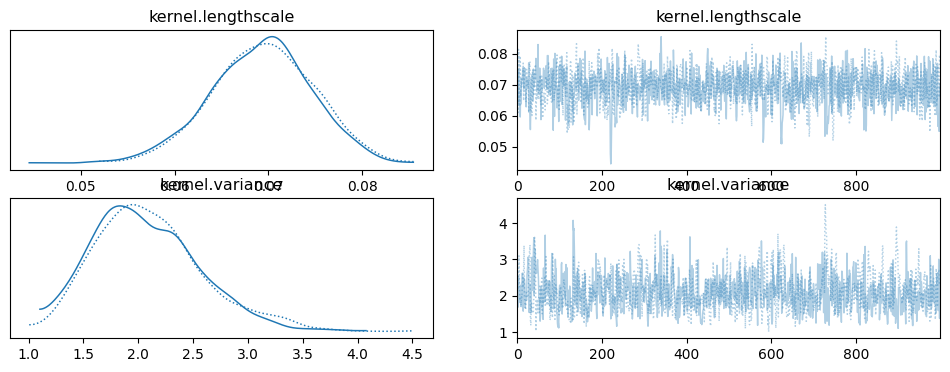

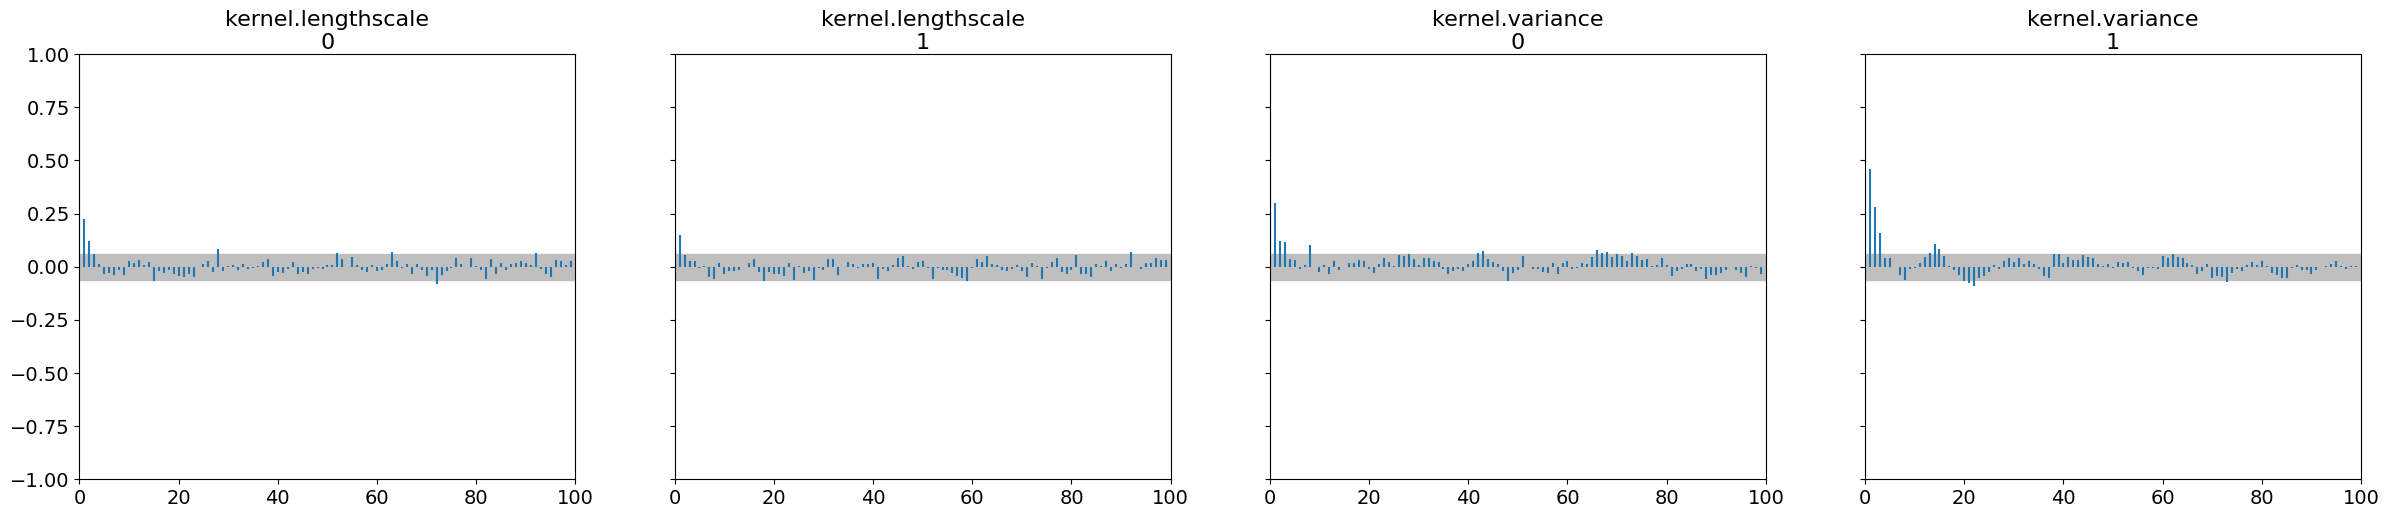

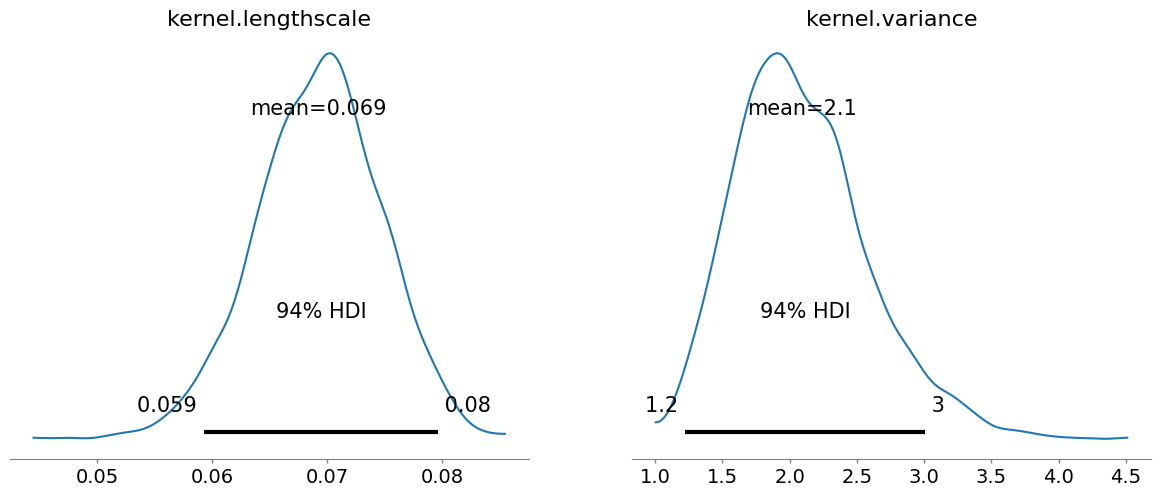

In [9]:
import arviz as az
from scipy.signal.windows import gaussian
import numpy as np



# Convert Pyro MCMC results to Arviz InferenceData
data = az.from_pyro(mcmc)

# Summarize the sampling diagnostics
summary = az.summary(data)
print(summary)

# Trace plot to assess convergence
az.plot_trace(data)
plt.show()

# Autocorrelation plot to assess the mixing of chains
az.plot_autocorr(data)
plt.show()

# Posterior plot to visualize the posterior distributions
az.plot_posterior(data)
plt.show()


In [12]:
# Define constants
num_datasets = 20
num_samples = 500  # Number of MCMC posterior samples to use
n_samples =500
test_likelihoods_map = []
test_likelihoods_mcmc = []

# Function to generate synthetic dataset
def generate_dataset():
    l = 30
    x = torch.linspace(0, 1, l).unsqueeze(-1)  # Shape (l, 1)
    y = g(x).squeeze() + torch.normal(0, 0.01, size=(l,))  # Shape (l,)
    indices = torch.randperm(l)
    train_indices = indices[:20]
    test_indices = indices[20:]
    return x[train_indices], y[train_indices], x[test_indices], y[test_indices]

In [13]:

# Extract posterior samples from MCMC
lengthscale_samples = posterior_samples["kernel.lengthscale"][:n_samples]
variance_samples = posterior_samples["kernel.variance"][:n_samples]

# Fixed noise parameter (from the earlier GP model definition)
noise = gpr.noise

# Initialize a list to store log-likelihoods
log_likelihoods = []

# Compute posterior likelihood for each sample
for i in range(n_samples):
    # Set kernel parameters using the sampled posterior values
    kernel.lengthscale = torch.tensor(lengthscale_samples[i].item())
    kernel.variance = torch.tensor(variance_samples[i].item())

    # Make predictions on the test data
    mean_test, variance_test = gpr(x_test, full_cov=False, noiseless=False)

    # Compute the log-likelihood of the test data
    test_likelihood = Normal(mean_test, variance_test.sqrt()).log_prob(y_test).sum()
    log_likelihoods.append(test_likelihood.item())

# Compute the mean of the log-likelihoods to get the approximate posterior likelihood
approx_posterior_likelihood = torch.tensor(log_likelihoods).mean().item()

print("Approximate posterior likelihood (test set):", approx_posterior_likelihood)


Approximate posterior likelihood (test set): -2.06101393699646


In [14]:
# Function to compute test likelihood for the MAP approach
def compute_test_likelihood_map(gpr_model, x_test, y_test):
    # Predict mean and variance on the test set
    mean_test, variance_test = gpr_model(x_test, full_cov=False, noiseless=False)

    # Compute the log-likelihood for the test set
    log_likelihood = Normal(mean_test, variance_test.sqrt()).log_prob(y_test).sum()
    return log_likelihood.item()

# Perform MAP optimization for a single dataset
def map_optimization(x_train, y_train):
    pyro.clear_param_store()
    kernel = gp.kernels.RBF(input_dim=1)
    gpr = gp.models.GPRegression(x_train, y_train, kernel, noise=torch.tensor(0.01))

    # Optimize using Adam to find MAP estimates
    optimizer = torch.optim.Adam(gpr.parameters(), lr=0.01)
    num_steps = 1000
    for _ in range(num_steps):
        optimizer.zero_grad()
        loss = loss_fn(gpr.model, gpr.guide)
        loss.backward()
        optimizer.step()

    return gpr


In [15]:
# Function to compute test likelihood for the MCMC approach
def compute_test_likelihood_mcmc(gpr_model, x_test, y_test, posterior_samples):
    log_likelihoods = []
    for i in range(len(posterior_samples['kernel.lengthscale'])):
        # Update kernel parameters with MCMC samples
        gpr_model.kernel.lengthscale = posterior_samples['kernel.lengthscale'][i]
        gpr_model.kernel.variance = posterior_samples['kernel.variance'][i]

        # Predict mean and variance on the test set
        mean_test, variance_test = gpr_model(x_test, full_cov=False, noiseless=False)

        # Compute the log-likelihood for the test set
        log_likelihood = Normal(mean_test, variance_test.sqrt()).log_prob(y_test).sum()
        log_likelihoods.append(log_likelihood.item())
    return np.mean(log_likelihoods)

def mcmc_sampling(x_train, y_train):
    pyro.clear_param_store()
    kernel = gp.kernels.RBF(input_dim=1)
    gpr = gp.models.GPRegression(x_train, y_train, kernel, noise=torch.tensor(0.01))

    # Define parameters as PyroSamples
    gpr.kernel.lengthscale = pyro.nn.PyroSample(dist.HalfNormal(0.05))
    gpr.kernel.variance = pyro.nn.PyroSample(dist.HalfNormal(1.0))

    # Rest of the code remains the same
    nuts_kernel = NUTS(gpr.model)
    mcmc = MCMC(nuts_kernel, num_samples=500, warmup_steps=200, num_chains=2)
    mcmc.run()

    return gpr, mcmc.get_samples()

In [16]:
# Define constants
num_datasets = 20
test_likelihoods_map = []
test_likelihoods_mcmc = []

# Generate 20 datasets and perform MAP and MCMC
for _ in range(num_datasets):
    # Generate dataset
    x_train, y_train, x_test, y_test = generate_dataset()

    # --- MAP Approach ---
    gpr_map = map_optimization(x_train, y_train)
    test_likelihood_map = compute_test_likelihood_map(gpr_map, x_test, y_test)
    test_likelihoods_map.append(test_likelihood_map)

    # --- MCMC Approach ---
    gpr_mcmc, posterior_samples = mcmc_sampling(x_train, y_train)
    test_likelihood_mcmc = compute_test_likelihood_mcmc(gpr_mcmc, x_test, y_test, posterior_samples)
    test_likelihoods_mcmc.append(test_likelihood_mcmc)

# Summarize and compare results
print("MAP Test Likelihoods (Mean ± Std):", np.mean(test_likelihoods_map), "±", np.std(test_likelihoods_map))
print("MCMC Test Likelihoods (Mean ± Std):", np.mean(test_likelihoods_mcmc), "±", np.std(test_likelihoods_mcmc))


/usr/local/lib/python3.10/dist-packages/pyro/infer/mcmc/api.py:499: UserWarning: num_chains=2 is more than available_cpu=1. Chains will be drawn sequentially.
  warnings.warn(
Sample [1]: 100%|██████████| 700/700 [00:18, 37.33it/s, step size=1.10e+00, acc. prob=0.913]


MAP Test Likelihoods (Mean ± Std): -6.505635666847229 ± 2.226110157723167
MCMC Test Likelihoods (Mean ± Std): 1.7600985861450433 ± 3.6049590207155076


## Don't run code below

In [25]:
import torch
import pyro
import pyro.contrib.gp as gp
from pyro.infer.mcmc import MCMC, NUTS
from pyro.distributions import Normal
import numpy as np



# Function to compute test likelihoods
def compute_test_likelihood(gpr_model, x_test, y_test, method="map", posterior_samples=None):
    log_likelihoods = []

    if method == "map":
        mean_test, variance_test = gpr_model(x_test, full_cov=False, noiseless=False)
        log_likelihood = Normal(mean_test, variance_test.sqrt()).log_prob(y_test).sum()
        return log_likelihood.item()

    elif method == "mcmc":
        for i in range(num_samples):
            # Set kernel parameters from MCMC samples
            gpr_model.kernel.lengthscale = posterior_samples['kernel.lengthscale'][i]
            gpr_model.kernel.variance = posterior_samples['kernel.variance'][i]

            # Predict on test set
            mean_test, variance_test = gpr_model(x_test, full_cov=False, noiseless=False)
            log_likelihood = Normal(mean_test, variance_test.sqrt()).log_prob(y_test).sum()
            log_likelihoods.append(log_likelihood.item())
        return np.mean(log_likelihoods)

# Repeat the procedure for 20 datasets
for _ in range(num_datasets):
    # Generate a new dataset
    x_train, y_train, x_test, y_test = generate_dataset()

    # Define the GP model
    pyro.clear_param_store()
    kernel = gp.kernels.RBF(input_dim=1)
    gpr = gp.models.GPRegression(x_train, y_train, kernel, noise=torch.tensor(0.01))

    # --- MAP Approach ---
    # Perform simple optimization to get MAP estimates
    optimizer = torch.optim.Adam(gpr.parameters(), lr=0.01)
    num_steps = 1000
    for _ in range(num_steps):
        optimizer.zero_grad()
        loss = loss_fn(gpr.model, gpr.guide)
        loss.backward()
        optimizer.step()

    # Compute test likelihood for MAP
    test_likelihood_map = compute_test_likelihood(gpr, x_test, y_test, method="map")
    test_likelihoods_map.append(test_likelihood_map)

    # --- MCMC (NUTS) Approach ---
    nuts_kernel = NUTS(gpr.model)
    mcmc = MCMC(nuts_kernel, num_samples=num_samples, warmup_steps=200, num_chains=2)
    mcmc.run()
    posterior_samples = mcmc.get_samples()

    # Compute test likelihood for MCMC
    test_likelihood_mcmc = compute_test_likelihood(gpr, x_test, y_test, method="mcmc", posterior_samples=posterior_samples)
    test_likelihoods_mcmc.append(test_likelihood_mcmc)

# Compare results
print("MAP Test Likelihoods (Mean ± Std):", np.mean(test_likelihoods_map), "±", np.std(test_likelihoods_map))
print("MCMC Test Likelihoods (Mean ± Std):", np.mean(test_likelihoods_mcmc), "±", np.std(test_likelihoods_mcmc))


Sample: 100%|██████████| 700/700 [00:00, 9472.66it/s, step size=1.00e+00, acc. prob=1.000]


KeyError: 'kernel.lengthscale'

In [ ]:
import torch
import pyro
import pyro.contrib.gp as gp
from pyro.distributions import Normal
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
from pyro.infer.mcmc import MCMC, NUTS
import numpy as np

# Parameters
num_datasets = 20
num_train = 20
num_test = 10
num_mcmc_samples = 500

# Define the true function
def g(x):
    return - (torch.sin(6 * np.pi * x))**2 + 6 * x**2 - 5 * x**4 + 3 / 2

# Container for results
map_likelihoods = []
mcmc_likelihoods = []

# Repeat for multiple datasets
for dataset_idx in range(num_datasets):
    print(f"Processing dataset {dataset_idx + 1} of {num_datasets}...")

    # Generate data
    l = num_train + num_test
    x = torch.linspace(0, 1, l).unsqueeze(-1)  # Shape (l, 1)
    y = g(x).squeeze() + torch.normal(0, 0.01, size=(l,))

    # Split into training and testing data
    indices = torch.randperm(l)
    train_indices = indices[:num_train]
    test_indices = indices[num_train:]

    x_train, y_train = x[train_indices], y[train_indices]
    x_test, y_test = x[test_indices], y[test_indices]

    # Reset Pyro parameters
    pyro.clear_param_store()

    # Define GP with RBF kernel
    kernel = gp.kernels.RBF(input_dim=1)
    gpr = gp.models.GPRegression(x_train, y_train, kernel, noise=torch.tensor(0.01))

    # Set priors on kernel parameters
    gpr.kernel.lengthscale = pyro.nn.PyroSample(pyro.distributions.HalfNormal(0.05))
    gpr.kernel.variance = pyro.nn.PyroSample(pyro.distributions.HalfNormal(1.0))

    # ----- MAP Approach -----
    optimizer = Adam({"lr": 0.01})
    svi = SVI(gpr.model, gpr.guide, optimizer, loss=Trace_ELBO())

    # Train the model with SVI
    num_steps = 1000
    for step in range(num_steps):
        svi.step()

    # Predict on test data
    with torch.no_grad():
        mean_test, variance_test = gpr(x_test, full_cov=False, noiseless=False)
        map_likelihood = Normal(mean_test, variance_test.sqrt()).log_prob(y_test).sum().item()
    map_likelihoods.append(map_likelihood)

    # ----- MCMC Approach -----
    nuts_kernel = NUTS(gpr.model)
    mcmc = MCMC(nuts_kernel, num_samples=num_mcmc_samples, warmup_steps=200, num_chains=2)
    mcmc.run()

    # Extract posterior samples
    posterior_samples = mcmc.get_samples()
    lengthscale_samples = posterior_samples["kernel.lengthscale"][:num_mcmc_samples]
    variance_samples = posterior_samples["kernel.variance"][:num_mcmc_samples]

    # Compute likelihoods for MCMC
    mcmc_test_likelihoods = []
    for i in range(num_mcmc_samples):
        # Set kernel parameters
        kernel.lengthscale = torch.tensor(lengthscale_samples[i].item())
        kernel.variance = torch.tensor(variance_samples[i].item())

        # Predict on test data
        mean_test, variance_test = gpr(x_test, full_cov=False, noiseless=False)

        # Compute test likelihood
        likelihood = Normal(mean_test, variance_test.sqrt()).log_prob(y_test).sum().item()
        mcmc_test_likelihoods.append(likelihood)

    # Average MCMC likelihoods
    avg_mcmc_likelihood = np.mean(mcmc_test_likelihoods)
    mcmc_likelihoods.append(avg_mcmc_likelihood)




In [ ]:
# ----- Compare Results -----
import matplotlib.pyplot as plt

# Convert results to arrays for analysis
map_likelihoods = np.array(map_likelihoods)
mcmc_likelihoods = np.array(mcmc_likelihoods)

# Plot comparison
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_datasets + 1), map_likelihoods, label="MAP Test Likelihoods", marker='o')
plt.plot(range(1, num_datasets + 1), mcmc_likelihoods, label="MCMC Test Likelihoods", marker='x')
plt.xlabel("Dataset Index")
plt.ylabel("Test Log-Likelihood")
plt.title("Comparison of MAP and MCMC Test Likelihoods Across Datasets")
plt.legend()
plt.grid()
plt.show()

# Print summary statistics
print("Summary of Results:")
print(f"MAP Mean Test Likelihood: {map_likelihoods.mean():.2f}, Std: {map_likelihoods.std():.2f}")
print(f"MCMC Mean Test Likelihood: {mcmc_likelihoods.mean():.2f}, Std: {mcmc_likelihoods.std():.2f}")